# Imports

In [1]:
# Remember to login to wandb!
import sys
import os 
import torch
import matplotlib.pyplot as plt
import copy 
# Append module directory for imports
parent_dir = os.path.expanduser('../eigenestimation')
sys.path.append(parent_dir)
import numpy as np
from toy_models.tms import AutoencoderSymmetric, GenerateTMSData, GenerateTMSDataParallel, AutoencoderParallel  # Import your model
from evaluation.networks import DrawNeuralNetwork
from eigenmodel.eigenmodel import EigenModel
from utils.loss import MSELoss

# Initial TMS Model

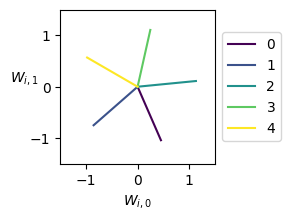

In [2]:
# Load TMS model
input_dim = 5
hidden_dim = 2
n_networks = 3
original_model = "../outputs/toy_models/tms.pt"

tms_model = AutoencoderSymmetric(input_dim=input_dim, hidden_dim=hidden_dim)
tms_model = torch.load(original_model)['model']

# Plot TMS representations.
en = copy.deepcopy(tms_model.W_in).detach().cpu().numpy().transpose()

plt.figure(figsize=(2,2))
# Iterate through different colors
colors = plt.cm.viridis(np.linspace(0, 1, en.shape[1]))

for i in range(en.shape[1]):
  plt.plot([0, en[0,i]], [0,en[1,i]], '-', color=colors[i], label=f'{i}',)
  # Label which index we are looking at on the end of its line
#  plt.text(1.3*en[0,i], 1.3*en[1,i], f'{i}')
# Legend outside plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('$W_{i,0}$')
plt.ylabel('$W_{i,1}$', rotation=0)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.savefig('../figures/tms_encoder_directions.svg', bbox_inches='tight', transparent=True)
plt.show()



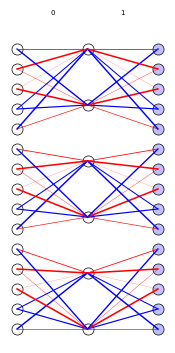

In [3]:
# Load TMS model
input_dim = 5
hidden_dim = 2
n_networks = 3
eigenmodel_path = "../outputs/eigenmodels/tms_parallel.pt"

tms_model_p = torch.load(eigenmodel_path)['model']

model_params = dict(tms_model_p.named_parameters())
weights = {k:v for k,v in model_params.items() if 'b' not in k}
weights = {str(i):v.transpose(0,1) for i,v in enumerate(weights.values())}

biases = {k:v for k,v in model_params.items() if 'b' in k}
biases = {str(i+1):v for i,v in enumerate(biases.values())}

f = DrawNeuralNetwork(weights, biases)
f.savefig('../figures/TMS_setup/tms_nn_parallel.svg', bbox_inches='tight', transparent=True)

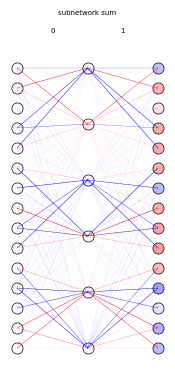

In [74]:
checkpoint = torch.load(eigenmodel_path)
eigenmodel = checkpoint['model']

model_params = eigenmodel.reconstruct_network()
weights = {k:v.transpose(0,1) for k,v in model_params.items() if 'b' not in k}
weights = {str(i):v for i,v in enumerate(weights.values())}

biases = {k:v for k,v in model_params.items() if 'b' in k}
biases = {str(i+1):v for i,v in enumerate(biases.values())}

figs = DrawNeuralNetwork(weights, biases, title='subnetwork sum')

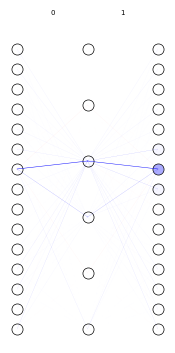

7


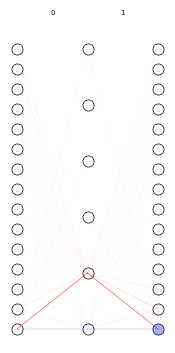

15


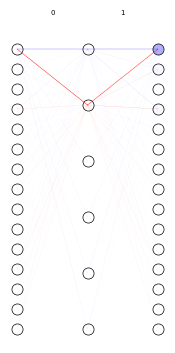

1


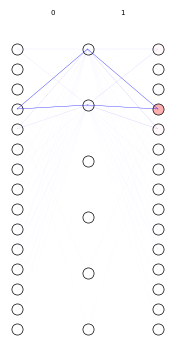

4


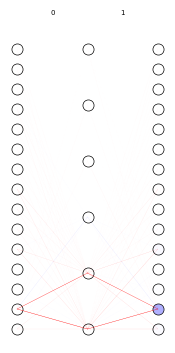

14


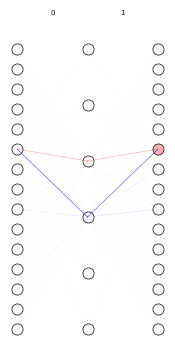

6


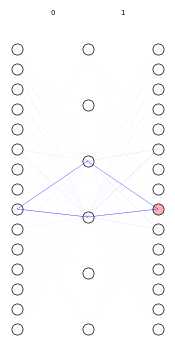

9


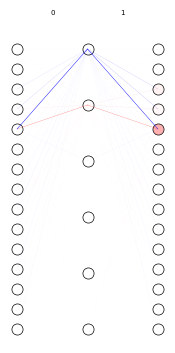

5


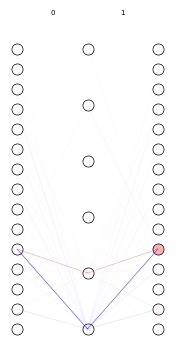

11


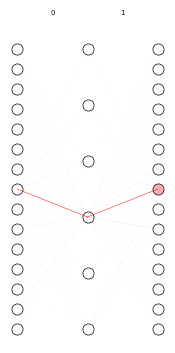

8


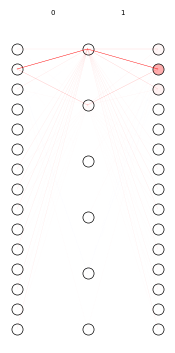

2


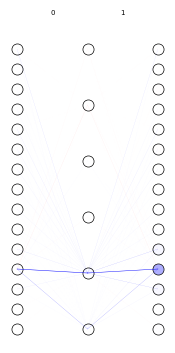

12


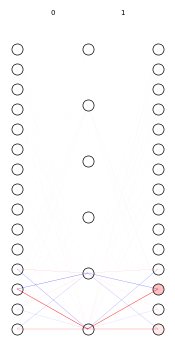

13


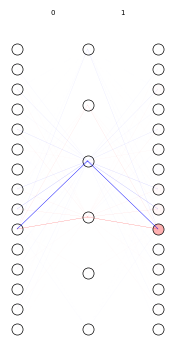

10


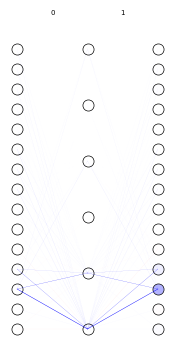

13


In [73]:
for i, network in enumerate(eigenmodel.construct_subnetworks()):
    weights = {k:v.transpose(0,1) for k,v in network.items() if 'b' not in k}
    weights = {str(i):v for i,v in enumerate(weights.values())}

    biases = {k:v for k,v in network.items() if 'b' in k}
    biases = {str(i+1):v for i,v in enumerate(biases.values())}

    f = DrawNeuralNetwork(weights, biases)
    feature = abs(biases['1']).argmax().item()
    print(15-feature)
    f.savefig(f'../figures/tms_subnetworks/tms_subnetwork_{15-feature}.svg', bbox_inches='tight', transparent=True)

In [125]:
# Geneate sparse features
from toy_models.tms import GenerateTMSData
import matplotlib.cm as cm
import matplotlib.colors as colors

subnetworks = eigenmodel.construct_subnetworks()

n_subnetworks = len(subnetworks)
n_features = 15
X, _ = GenerateTMSData(num_features=n_features, num_datapoints=5000, sparsity=.05, batch_size=32)

In [136]:
gradients = eigenmodel.compute_gradients(X)
jvp = eigenmodel(gradients)

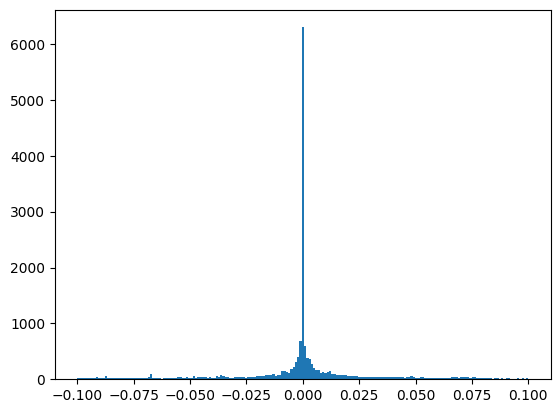

In [173]:
plt.hist(jvp.flatten().cpu().detach().numpy(), bins=np.linspace(-.1,.1,200))
plt.show()

In [159]:
print(jvp[:12,0])

tensor([-4.2971e-01, -3.3802e-02,  0.0000e+00, -1.0459e-02,  8.1928e-02,
        -3.2478e-01,  3.3274e+00,  6.9976e+00, -1.1924e+00, -9.8948e-02,
        -7.6153e-02,  3.3506e+01], device='cuda:0', grad_fn=<SelectBackward0>)


In [171]:
X[11]

tensor([0.0000, 0.8068, 0.5656, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.1239, 0.0000], device='cuda:0')

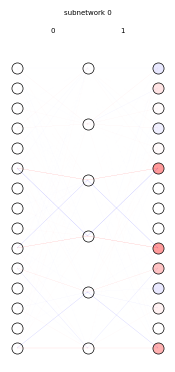

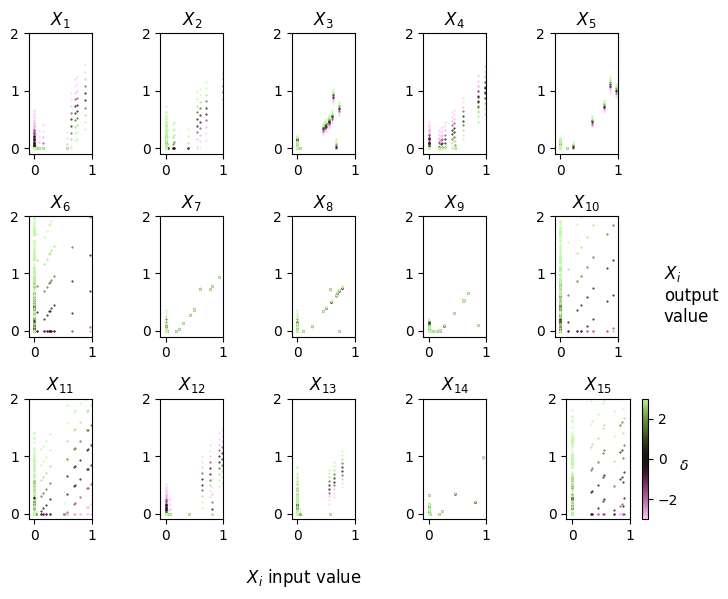

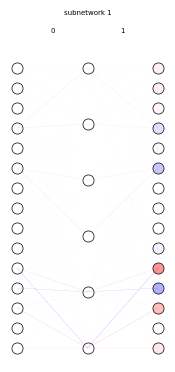

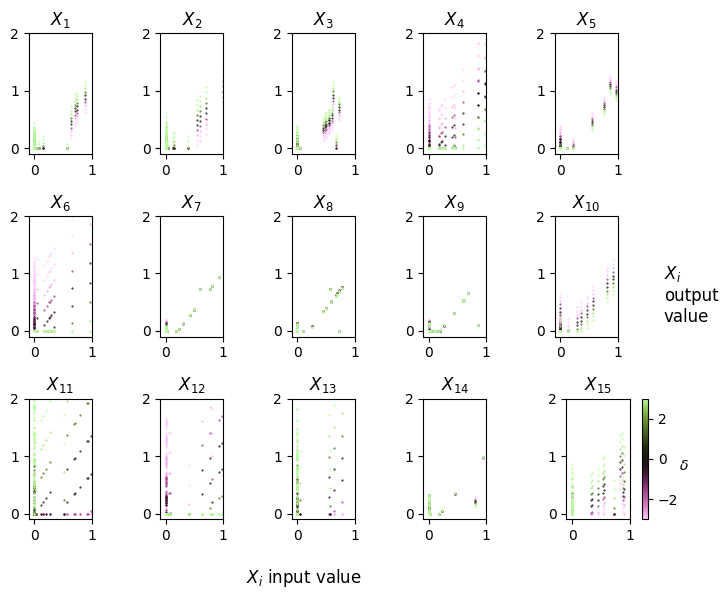

In [141]:
# Geneate sparse features
from toy_models.tms import GenerateTMSData
import matplotlib.cm as cm
import matplotlib.colors as colors

subnetworks = eigenmodel.construct_subnetworks()

n_subnetworks = len(subnetworks)
n_features = 15
X, _ = GenerateTMSData(num_features=n_features, num_datapoints=200, sparsity=.05, batch_size=32)


toy_model = copy.deepcopy(eigenmodel.model)
y_orig = toy_model(X).cpu().detach().numpy()

figs = []


    
    
for subnetwork_idx in range(2):
    
    
    weights = {k:v.transpose(0,1) for k,v in subnetworks[subnetwork_idx].items() if 'b' not in k}
    weights = {str(i):v for i,v in enumerate(weights.values())}

    biases = {k:v for k,v in subnetworks[subnetwork_idx].items() if 'b' in k}
    biases = {str(i+1):v for i,v in enumerate(biases.values())}

    
    f = DrawNeuralNetwork(weights, biases, title=f'subnetwork {subnetwork_idx}')
    f.savefig(f'../figures/tms_subnetworks/tms_subnetwork_{subnetwork_idx+1}.svg', bbox_inches='tight', transparent=True)
    
    n_cols = 5  # You can adjust this number to change the grid layout
    n_rows = (n_features + n_cols - 1) // n_cols  # Ceiling division to ensure all plots fit



    norm = colors.Normalize(vmin=-3, vmax=3)  # normalize based on feature_coeff range
    cmap = plt.cm.vanimo  # you can choose different colormaps like 'viridis', 'plasma', 'magma', etc.

    
    # Create figure with subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, 2*n_rows))
    axes = axes.flatten()  # Flatten axes array for easier indexing    
    # Create individual scatter plots
    for i in range(n_features):

    
        for feature_coeff in np.linspace(-5,5, 10):
            feature_coefficients = torch.zeros(eigenmodel.n_features).to('cuda')
    
            # Iterate through different values of features coefficient and plot on the
            feature_coefficients[subnetwork_idx] = feature_coeff
            reconstruction = eigenmodel.add_to_network(feature_coefficients)
            # Repalce toy model parameters with model_params
            toy_model.load_state_dict(reconstruction)
            y = (toy_model(X)).cpu().detach().numpy()
        # Calculate number of rows and columns for subplots grid
            axes[i].plot(X[:,-(i+1)].detach().cpu().numpy(), y[:,-(i+1)],#X[:,-(i+1)].cpu().detach().numpy(), y[:,-(i+1)], 
                         '.', 
                        label=f"feature coeff {feature_coeff}", markersize=1, color=cmap(norm(feature_coeff)))# vmin=-3, vmax=3)

        axes[i].set_title(f'$X_{{{i+1}}}$')
        # Make my plots have the same x and y ratios
        axes[i].set_ylim(-.1,2)
        axes[i].set_xlim(-.1,1)

        axes[i].set_aspect('equal', 'box')
        
    # Remove any empty subplots
    for i in range(n_features, len(axes)):
        fig.delaxes(axes[i])
        
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Needed for colorbar compatibility

    # Add a colorbar outside all subplots
    cbar = fig.colorbar(sm, ax=axes[-1], orientation='vertical', fraction=0.05, pad=0.1, location='right')
    cbar.set_label("$\delta$", rotation=0,loc='center', size=10)
    plt.subplots_adjust(wspace=0, hspace=0)  # Adjust these values as needed    

    # Set sup y label and x label
    
    fig.supxlabel('$X_{{i}}$ input value')
    # Rotate ylabel
    fig.supylabel('$X_{{i}}$ \noutput\nvalue', rotation=0, x=.95)
    
    plt.tight_layout()
    plt.savefig(f'../figures/tms_subnetworks/tms_feature_values_{subnetwork_idx+1}.svg', bbox_inches='tight', transparent=True)
    plt.show()
    



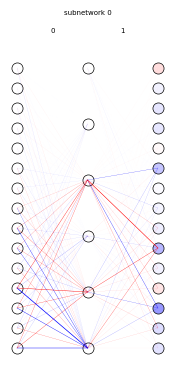

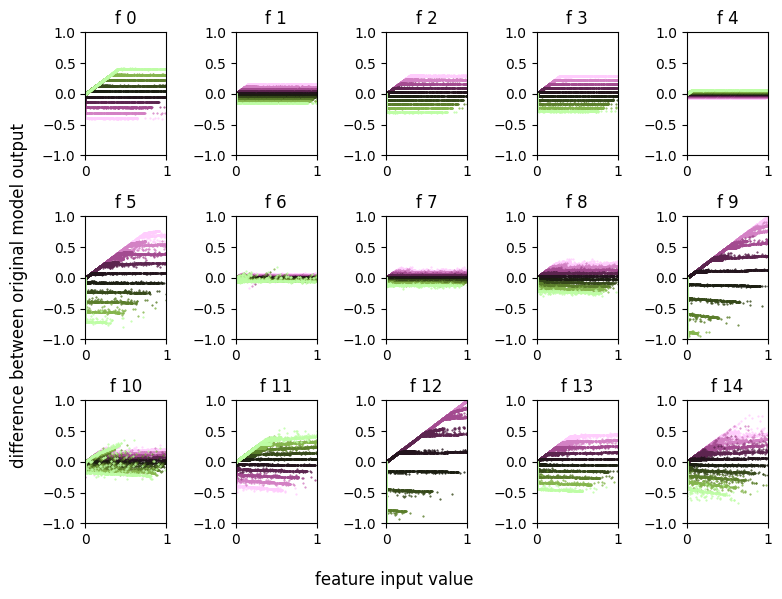

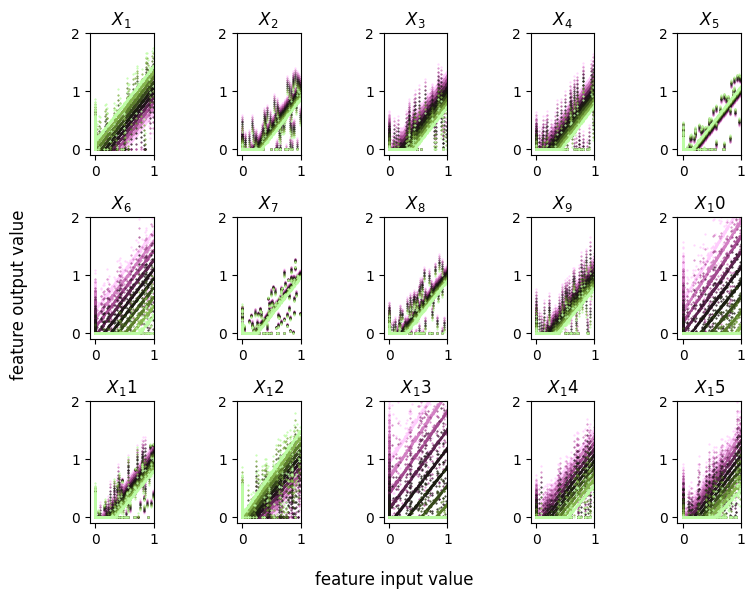

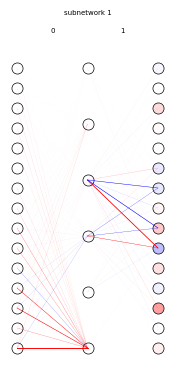

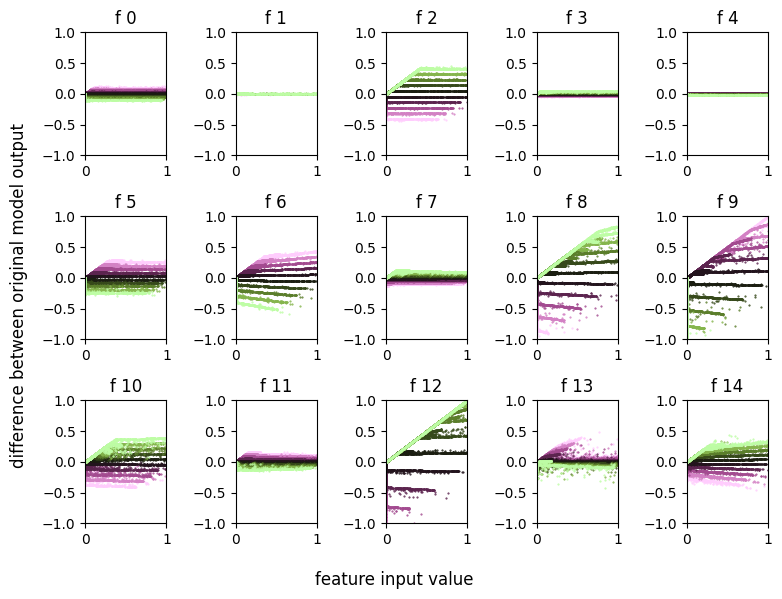

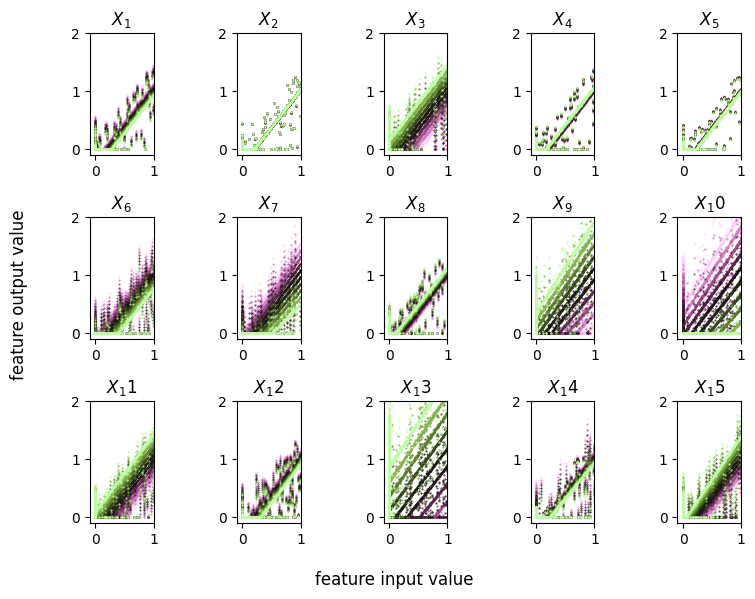

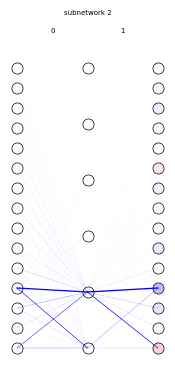

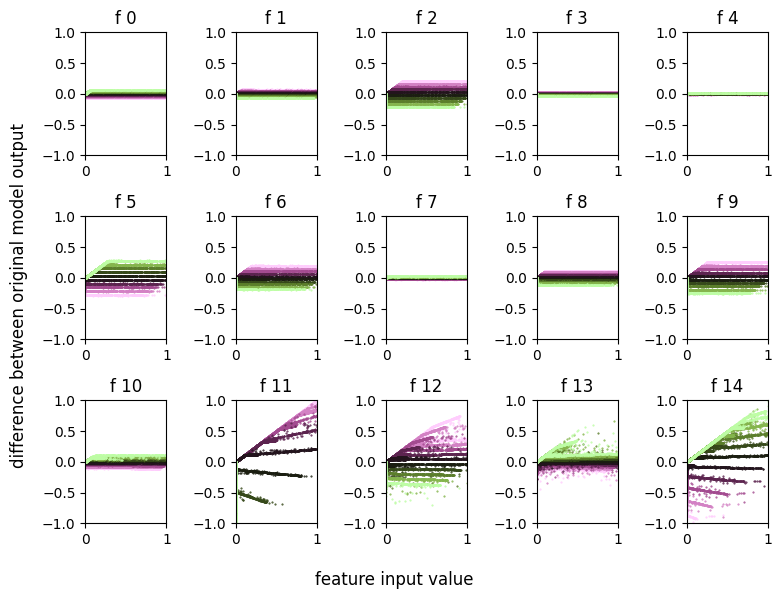

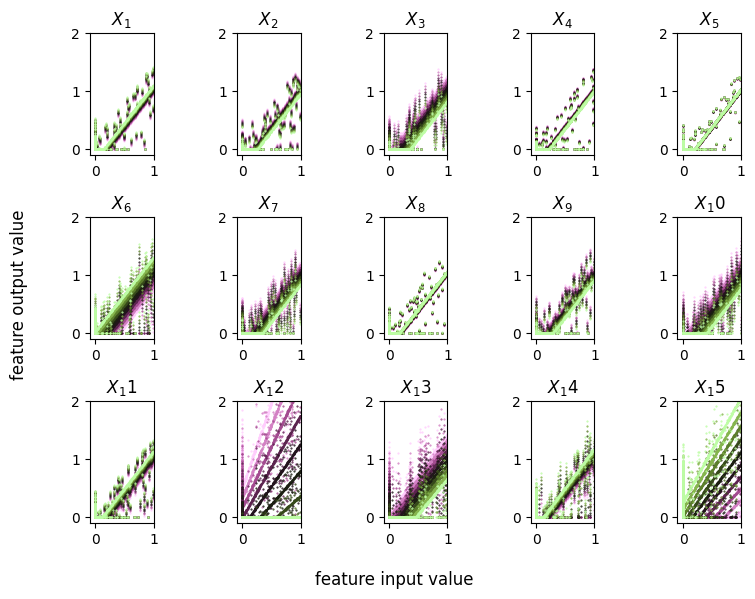

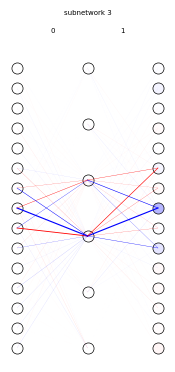

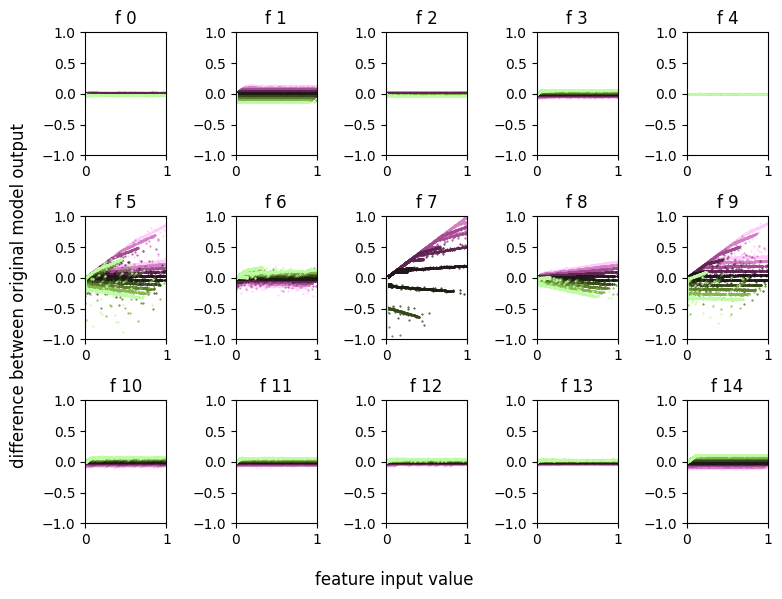

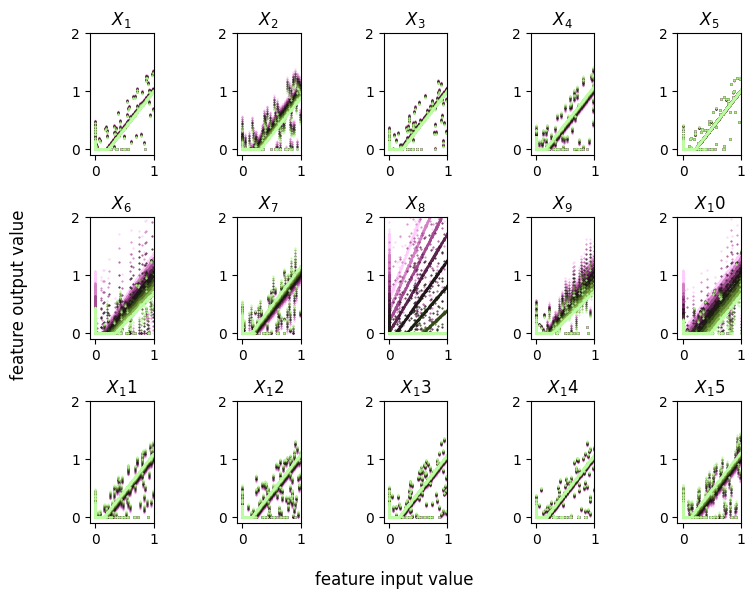

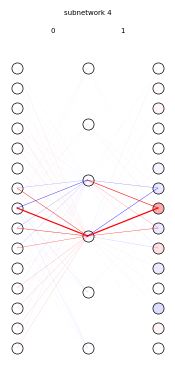

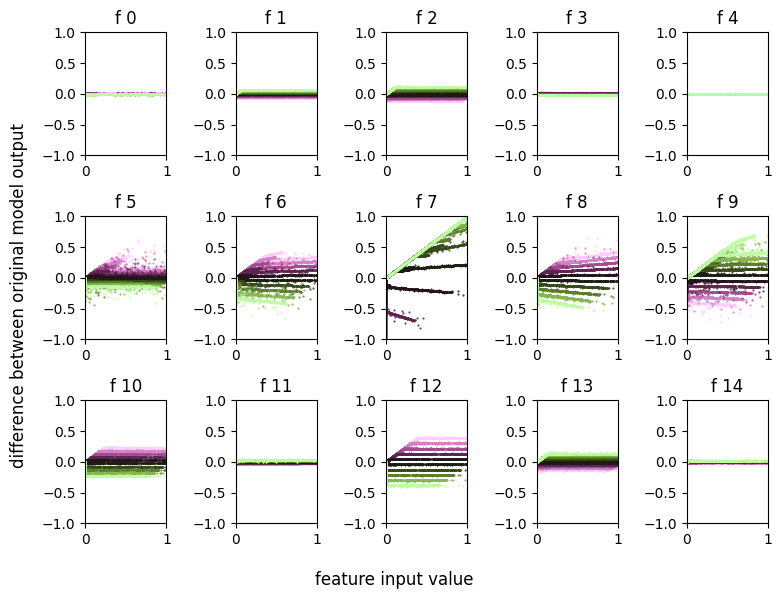

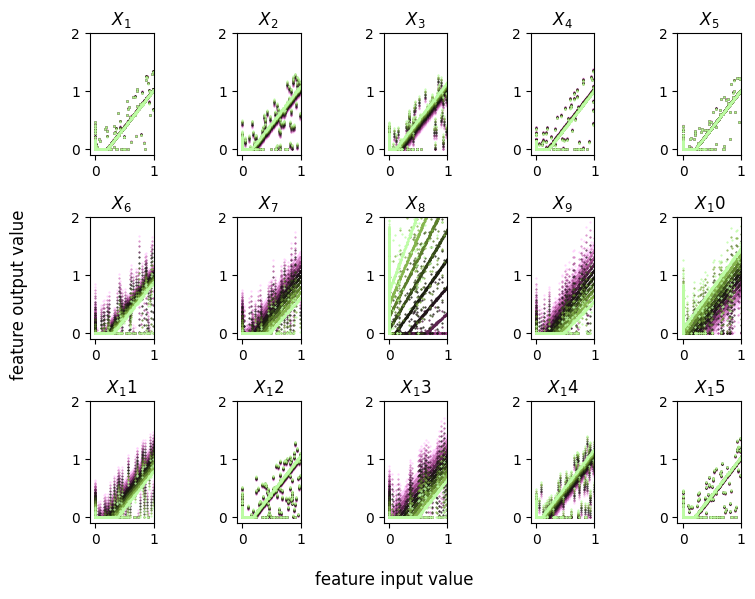

In [9]:
# Geneate sparse features
from toy_models.tms import GenerateTMSData

subnetworks = eigenmodel.construct_subnetworks()

n_subnetworks = len(subnetworks)
n_features = 15
X, _ = GenerateTMSData(num_features=n_features, num_datapoints=10000, sparsity=.05, batch_size=32)


toy_model = copy.deepcopy(eigenmodel.model)
y_orig = toy_model(X).cpu().detach().numpy()

figs = []

import matplotlib.colors as colors

    
    
for subnetwork_idx in range(5):
    
    
    weights = {k:v.transpose(0,1) for k,v in subnetworks[subnetwork_idx].items() if 'b' not in k}
    weights = {str(i):5*v for i,v in enumerate(weights.values())}

    biases = {k:v for k,v in subnetworks[subnetwork_idx].items() if 'b' in k}
    biases = {str(i+1):v for i,v in enumerate(biases.values())}

    
    DrawNeuralNetwork(weights, biases, title=f'subnetwork {subnetwork_idx}')
    
    
    n_cols = 5  # You can adjust this number to change the grid layout
    n_rows = (n_features + n_cols - 1) // n_cols  # Ceiling division to ensure all plots fit



    norm = colors.Normalize(vmin=-3, vmax=3)  # normalize based on feature_coeff range
    cmap = plt.cm.vanimo  # you can choose different colormaps like 'viridis', 'plasma', 'magma', etc.
    
    
    # Create figure with subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, 2*n_rows))
    axes = axes.flatten()  # Flatten axes array for easier indexing    
    # Create individual scatter plots
    for i in range(n_features):
        

    
        for feature_coeff in np.linspace(-3,3, 10):
            feature_coefficients = torch.zeros(eigenmodel.n_features).to('cuda')
    
            # Iterate through different values of features coefficient and plot on the
            feature_coefficients[subnetwork_idx] = feature_coeff
            reconstruction = eigenmodel.add_to_network(feature_coefficients)
            # Repalce toy model parameters with model_params
            toy_model.load_state_dict(reconstruction)
            y = (toy_model(X)).cpu().detach().numpy()
        # Calculate number of rows and columns for subplots grid
            axes[i].plot(y[:,-(i+1)], y[:,-(i+1)]-y_orig[:,-(i+1)],#X[:,-(i+1)].cpu().detach().numpy(), y[:,-(i+1)], 
                         '.', 
                        label=f"feature coeff {feature_coeff}", markersize=1, color=cmap(norm(feature_coeff)))# vmin=-3, vmax=3)
            
        axes[i].set_title(f'f {i}')
        # Make my plots have the same x and y ratios
        axes[i].set_ylim(-1,1)
        axes[i].set_xlim(0,1)

        #axes[i].set_aspect('equal', 'box')
        
    # Remove any empty subplots
    for i in range(n_features, len(axes)):
        fig.delaxes(axes[i])

    fig.supxlabel('feature input value')
    fig.supylabel('difference between original model output')
    
    plt.subplots_adjust(wspace=0, hspace=0)  # Adjust these values as needed    
    plt.tight_layout()
    plt.show()
    
    
    
    # Create figure with subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, 2*n_rows))
    axes = axes.flatten()  # Flatten axes array for easier indexing    
    # Create individual scatter plots
    for i in range(n_features):

    
        for feature_coeff in np.linspace(-3,3, 10):
            feature_coefficients = torch.zeros(eigenmodel.n_features).to('cuda')
    
            # Iterate through different values of features coefficient and plot on the
            feature_coefficients[subnetwork_idx] = feature_coeff
            reconstruction = eigenmodel.add_to_network(feature_coefficients)
            # Repalce toy model parameters with model_params
            toy_model.load_state_dict(reconstruction)
            y = (toy_model(X)).cpu().detach().numpy()
        # Calculate number of rows and columns for subplots grid
            axes[i].plot(X[:,-(i+1)].detach().cpu().numpy(), y[:,-(i+1)],#X[:,-(i+1)].cpu().detach().numpy(), y[:,-(i+1)], 
                         '.', 
                        label=f"feature coeff {feature_coeff}", markersize=1, color=cmap(norm(feature_coeff)))# vmin=-3, vmax=3)
            
        axes[i].set_title(f'$X_{i+1}$')
        # Make my plots have the same x and y ratios
        axes[i].set_ylim(-.1,2)
        axes[i].set_xlim(-.1,1)

        axes[i].set_aspect('equal', 'box')
        
    # Remove any empty subplots
    for i in range(n_features, len(axes)):
        fig.delaxes(axes[i])

    plt.subplots_adjust(wspace=0, hspace=0)  # Adjust these values as needed    

    # Set sup y label and x label
    fig.supxlabel('feature input value')
    fig.supylabel('feature output value')
    
    plt.tight_layout()
    plt.show()
    


    #plt.figure(figsize=(2,2))
    #for i in range(y.shape[1]):
    #    plt.hist(X[:,-i].cpu().detach().numpy()-y[:,-i], label=f"feature {i}#",  bins=np.linspace(-1,1,100), alpha=.5) #, bins=np.linspace(-.1,.1,100), alpha=.5)
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
   # plt.yscale('log')
    #plt.show()



In [10]:
2*torch.rand(10).round()-1

tensor([-1., -1., -1.,  1.,  1., -1.,  1.,  1.,  1.,  1.])

In [11]:
cmap(-.1)

(1.0, 0.80346, 0.99215, 1.0)

In [12]:
top_samples = RetrieveWandBArtifact(project_path="brianna-chrisman-2024/Eigenestimation/eigenestimation_tms_model_parallel", metric_name="TopActivatingSamples")



eigenmodel = EigenHora(tms_model_p, None, loss.MSELoss(), len(top_samples), 1, device=device).to(device)
eigenmodel.low_rank = RetrieveWandBArtifact(project_path="brianna-chrisman-2024/Eigenestimation/eigenestimation_tms_model_parallel", metric_name="subnetworks")

NameError: name 'RetrieveWandBArtifact' is not defined